# Ch4: Using LangGraph to add memory

## step 1: define the state of the graph

In [1]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
builder = StateGraph(State)

## Step 2: add node(s)

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI()

def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}

builder.add_node("chatbot", chatbot)

# step 3: add edges
Tell the graph where to start, and where to exit


In [3]:
builder.add_edge(START, 'chatbot')

#optional
builder.add_edge('chatbot', END)

graph = builder.compile()

# You can draw a visual representation of the graph

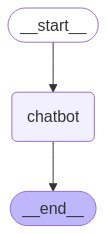

In [6]:
from IPython.display import Image, display
display(
    Image(graph.get_graph().draw_mermaid_png())
)

In [8]:
# run it
from langchain_core.messages import HumanMessage
input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BTUIcItjBuRsHGeLc07DS2JU5t7Cy', 'finish_reason': 'stop', 'logprobs': None}, id='run--592a5dac-a4b4-45ec-b681-af66cbb88357-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


## Adding memory to stetegraph
there are several adapters from databases to inmemory eg:
- sqllite
- postgres
- redis
- mysql

In [11]:
#use inmemory to store messages
from langgraph.checkpoint.memory import MemorySaver
graph = builder.compile(checkpointer=MemorySaver())


### Threads == session
use threads (unique identifier for a 'conversation') to manage different chats



In [15]:
thread1 = {"configurable": {"thread_id": "1"}}
result_1 = graph.invoke(
    {"messages": [HumanMessage("Hi, my name is Allan")]},
    thread1
)
result_2 = graph.invoke(
    {"messages": HumanMessage("what is my name?")}, thread1
)
print(result_1, result_2)

{'messages': [HumanMessage(content='Hi, my name is Allan', additional_kwargs={}, response_metadata={}, id='d29e1529-3bab-4f6c-a89a-a165c4061af5'), AIMessage(content='Nice to meet you, Allan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 13, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BTUi6YG9JKR0uP0STVvgDlRB5hFTd', 'finish_reason': 'stop', 'logprobs': None}, id='run--1683b1b0-80ea-4319-8e05-c9601407b1b2-0', usage_metadata={'input_tokens': 13, 'output_tokens': 15, 'total_tokens': 28, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]} {'messages': [HumanMessage(content='Hi, m

In [18]:
# you can also update state
graph.get_state(thread1)
graph.update_state(
    thread1, 
    {"messages": [HumanMessage('I like LLMs!')]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f028f57-769d-6ae2-8005-1ff4b9211f13'}}

## Filtering and trimming message
Trimming is necessary because most LLMs have a limited context window

In [24]:
# define trimmer
from langchain_core.messages import trim_messages, SystemMessage, AIMessage, filter_messages
trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o"),
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [25]:
filter_messages(messages, include_types="human")

[HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={})]